# Plan

1. Figures on missing data
    - How many sites do not have any data at all from March - November
    - How many sites do not have any data within x number of pixels
    - % coverage for sites across time
    
2. Decide what to do with missing data

3. Feature: Get one figure for every time + site pair
    - Mean / Median / Quantile of non-missing data around the point (all 11 x 11 pixels)
    - Mean / Median / Quantile of non-missing data around the point (less pixels, maybe 3 x 3 / 5 x 5)

Post Feature Extraction:
1. EDA
2. Binary Classifier

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import netCDF4 as nc

# Load Dataset

In [2]:
# replace with path to sites_data_51x51.csv
df = pd.read_csv("/Users/yuhanwang/Desktop/CourseMaterial/Capstone/capstone-project-sewage-pollution/sites_data_51x51.csv")
#df['Pixel Index'] = np.arange(1,10202).tolist() * 430 * 237
df

,time,lat,lon,TUR,SPM,CHL,site
0,2020-01-04,52.655093,1.733927,75.791490,57.119390,10.334003,ukh1303-10400
1,2020-01-04,52.655093,1.735674,75.522590,58.450360,9.273168,ukh1303-10400
2,2020-01-04,52.655093,1.737421,69.529670,52.376694,9.113760,ukh1303-10400
3,2020-01-04,52.655093,1.739168,65.611430,48.540340,8.395749,ukh1303-10400
4,2020-01-04,52.655093,1.740915,66.520600,49.696520,7.250048,ukh1303-10400
...,...,...,...,...,...,...,...
134225833,2022-12-29,52.546759,1.770615,48.331380,37.388218,5.401901,ukh1303-10650
134225834,2022-12-29,52.546759,1.772362,53.736130,42.052635,5.581755,ukh1303-10650
134225835,2022-12-29,52.546759,1.774109,54.029140,41.245102,5.807971,ukh1303-10650
134225836,2022-12-29,52.546759,1.775856,52.296604,39.743805,5.866353,ukh1303-10650


In [3]:
len(df['time'].unique())

624

In [4]:
len(df['site'].unique())

417

In [5]:
sites_df = pd.read_csv('~data/site.csv')
sites = [[row['label'], row['EUBWID'], row['lat'], row['long']] for index, row in sites_df.iterrows()]

ds = nc.Dataset("~data/cmems_obs_oc_nws_bgc_tur-spm-chl_nrt_l4-hr-mosaic_P1D-m_1685923516879.nc")
lats = ds['lat'][:].data
lons = ds['lon'][:].data

sites_grid = []
for site in sites:
    lat_orig = site[2]
    lon_orig = site[3]
    
    j = 25 # this returns 51 x 51 grid with site at the center
    
    lat_grid = lats[np.argmin(np.abs(lats - lat_orig))]
    lon_grid = lons[np.argmin(np.abs(lons - lon_orig))]
    
    lat_grid_left = lats[np.argmin(np.abs(lats - lat_orig))-j]
    lon_grid_left = lons[np.argmin(np.abs(lons - lon_orig))-j]
    
    lat_grid_right = lats[np.argmin(np.abs(lats - lat_orig))+j]
    lon_grid_right = lons[np.argmin(np.abs(lons - lon_orig))+j]
    
    sites_grid.append([site[0], site[1], lat_orig, lon_orig, lat_grid, lon_grid, 
                       lat_grid_left, lon_grid_left, lat_grid_right, lon_grid_right])

sites_dict = {site[1]: {'lat': site[4], 'lon': site[5], 
                        'lat_min': site[8], 'lat_max': site[6],
                        'lon_min': site[7], 'lon_max': site[9]} for site in sites_grid}
sites_dict

{'ukd5300-41300': {'lat': 53.60787037037037,
  'lon': -3.0634171907756738,
  'lat_min': 53.584722222222226,
  'lat_max': 53.631018518518516,
  'lon_min': -3.1070929419985944,
  'lon_max': -3.0197414395527513},
 'ukd1101-46100': {'lat': 54.768055555555556,
  'lon': -3.433787561146044,
  'lat_min': 54.74490740740741,
  'lat_max': 54.7912037037037,
  'lon_min': -3.4774633123689647,
  'lon_max': -3.3901118099231216},
 'ukd1101-46000': {'lat': 54.743981481481484,
  'lon': -3.4564989517819615,
  'lat_min': 54.72083333333333,
  'lat_max': 54.76712962962963,
  'lon_min': -3.500174703004884,
  'lon_max': -3.412823200559041},
 'ukc2101-04250': {'lat': 55.32546296296296,
  'lon': -1.5522361984626052,
  'lat_min': 55.302314814814814,
  'lat_max': 55.34861111111111,
  'lon_min': -1.5959119496855259,
  'lon_max': -1.5085604472396845},
 'ukf3102-09400': {'lat': 53.25972222222222,
  'lon': 0.32582110412299947,
  'lat_min': 53.23657407407407,
  'lat_max': 53.28287037037037,
  'lon_min': 0.2821453529000

In [43]:
def get_grid_index(line):
    
    site_info = sites_dict[line['site']]

    lat_step = (site_info['lat_max'] - site_info['lat_min']) / 50
    lon_step = (site_info['lon_max'] - site_info['lon_min']) / 50

    lat_index = np.floor((line['lat'] - site_info['lat_min']) / lat_step)
    lon_index = np.floor((line['lon'] - site_info['lon_min']) / lon_step)
    
    grid_index = int(lat_index * 51 + lon_index + 1)
    
    return grid_index

In [44]:
df['grid_index'] = df.apply(get_grid_index, axis=1)
df

,time,lat,lon,TUR,SPM,CHL,site,grid_index
0,2020-01-04,52.655093,1.733927,75.791490,57.119390,10.334003,ukh1303-10400,2571
1,2020-01-04,52.655093,1.735674,75.522590,58.450360,9.273168,ukh1303-10400,2572
2,2020-01-04,52.655093,1.737421,69.529670,52.376694,9.113760,ukh1303-10400,2573
3,2020-01-04,52.655093,1.739168,65.611430,48.540340,8.395749,ukh1303-10400,2574
4,2020-01-04,52.655093,1.740915,66.520600,49.696520,7.250048,ukh1303-10400,2574
...,...,...,...,...,...,...,...,...
134225833,2022-12-29,52.546759,1.770615,48.331380,37.388218,5.401901,ukh1303-10650,47
134225834,2022-12-29,52.546759,1.772362,53.736130,42.052635,5.581755,ukh1303-10650,48
134225835,2022-12-29,52.546759,1.774109,54.029140,41.245102,5.807971,ukh1303-10650,48
134225836,2022-12-29,52.546759,1.775856,52.296604,39.743805,5.866353,ukh1303-10650,50


# Mean, Median, Q1, Q3 for every time + site pair

In [46]:
def mean_median_over_pixel_grid(dim):
    '''
    inputs:
        - Grid dimension (integer, 1 / 3 / 5 / 7 / 9 / 11 ...)
        
    output:
        - dataframe with the following columns:
            - Time
            - Site
            - 12 columns for every combination of TUR/SPM/CHL x median/mean/q1/q3
    '''
    # Dataframe with only relevant pixels based on grid dimension
    i = int((dim-1)/2)
    indices = np.array(range(1,2602)).reshape(51,51)[25-i:26+i, 25-i:26+i].flatten()
    df1 = df[df['grid_index'].isin(indices)]
    
    # Mean, Median, Quantiles
    median = df1.groupby(['time', 'site']).median().drop(['lat','lon', 'grid_index'], axis=1).add_suffix(f'_{dim}x{dim}_median')
    mean = df1.groupby(['time', 'site']).mean().drop(['lat','lon', 'grid_index'], axis=1).add_suffix(f'_{dim}x{dim}_mean')
    q1 = df1.groupby(['time', 'site']).quantile(0.25).drop(['lat','lon', 'grid_index'], axis=1).add_suffix(f'_{dim}x{dim}_q1')
    q3 = df1.groupby(['time', 'site']).quantile(0.75).drop(['lat','lon', 'grid_index'], axis=1).add_suffix(f'_{dim}x{dim}_q3')
    df2 = reduce(lambda  left,right: pd.merge(left,right,on=['time', 'site'],how='outer'), [median, mean, q1, q3])
       
    return df2

In [47]:
%%time
dfs = []

for dim in list(range(1,52,2)):
    dfs.append(mean_median_over_pixel_grid(dim))

CPU times: user 1h 55min 58s, sys: 10min 21s, total: 2h 6min 19s
Wall time: 2h 31min 30s


In [48]:
features_df = reduce(lambda left, right: pd.merge(left, right, on=['time', 'site'],how='outer'), dfs)
features_df.head()

TUR_1x1_median  SPM_1x1_median  CHL_1x1_median  \
time       site                                                            
2020-01-04 ukf3102-09100       108.93730       82.804050        9.694109   
           ukf3102-09200       116.36637       92.065480        9.894425   
           ukf3102-09400       107.69669       86.643550       13.944178   
           ukf3102-09600       157.11348      131.455100       14.738614   
           ukf3102-09700       117.12625       93.854904       12.754065   

                          TUR_1x1_mean  SPM_1x1_mean  CHL_1x1_mean  \
time       site                                                      
2020-01-04 ukf3102-09100     108.93730     82.804050      9.694109   
           ukf3102-09200     116.36637     92.065480      9.894425   
           ukf3102-09400     107.69669     86.643550     13.944178   
           ukf3102-09600     157.11348    131.455100     14.738614   
           ukf3102-09700     117.12625     93.854904     12.754065   

                          TUR_1x1_q1  SPM_1x1_q1  CHL_1x1_q1  TUR_1x1_q3  ...  \
time       site                                                           ...   
2020-01-04 ukf3102-09100   108.93730   82.804050    9.694109   108.93730  ...   
           ukf3102-09200   116.36637   92.065480    9.894425   116.36637  ...   
           ukf3102-09400   107.69669   86.643550   13.944178   107.69669  ...   
           ukf3102-09600   157.11348  131.455100   14.738614   157.11348  ...   
           ukf3102-09700   117.12625   93.854904   12.754065   117.12625  ...   

                          CHL_51x51_median  TUR_51x51_mean  SPM_51x51_mean  \
time       site                                                              
2020-01-04 ukf3102-09100          7.786972       56.991574       39.174789   
           ukf3102-09200          8.937684       64.657951       45.736671   
           ukf3102-09400          9.186992       69.629040       49.706337   
           ukf3102-09600          8.160086       52.962076       37.057555   
           ukf3102-09700          7.084467       31.324775       20.877057   

                          CHL_51x51_mean  TUR_51x51_q1  SPM_51x51_q1  \
time       site                                                        
2020-01-04 ukf3102-09100        8.061594     43.640497     28.339942   
           ukf3102-09200        9.018375     49.536735     32.876476   
           ukf3102-09400        9.381335     60.110758     41.077278   
           ukf3102-09600        8.556871     38.118608     24.710560   
           ukf3102-09700        7.982920     17.733513     10.922977   

                          CHL_51x51_q1  TUR_51x51_q3  SPM_51x51_q3  \
time       site                                                      
2020-01-04 ukf3102-09100      6.656758     61.104443     41.905066   
           ukf3102-09200      7.464715     68.959285     48.319313   
           ukf3102-09400      8.235911     73.797290     53.108590   
           ukf3102-09600      7.108883     63.412932     44.594133   
           ukf3102-09700      6.416773     34.601340     22.003967   

                          CHL_51x51_q3  
time       site                         
2020-01-04 ukf3102-09100      9.190117  
           ukf3102-09200     10.118837  
           ukf3102-09400     10.310409  
           ukf3102-09600      9.660246  
           ukf3102-09700      8.369608  

[5 rows x 312 columns]

In [49]:
# rows = 237 (days) x 430 (sites)
# column = 3 (TUR, SPM, CHL) x 4 (mean, median, q1, q3) x 6 (1x1/3x3/5x5/7x7/9x9/11x11)
features_df.shape

(113426, 312)

In [50]:
features_df.to_csv("feature_extraction_51x51.csv")

In [53]:
df.groupby(['time', 'site']).count()

lat   lon   TUR   SPM   CHL  grid_index
time       site                                                   
2020-01-04 ukf3102-09100  1171  1171  1171  1171  1171        1171
           ukf3102-09200  1231  1231  1231  1231  1231        1231
           ukf3102-09300  1317  1317  1317  1317  1317        1317
           ukf3102-09400  1275  1275  1275  1275  1275        1275
           ukf3102-09500  1201  1201  1201  1201  1201        1201
...                        ...   ...   ...   ...   ...         ...
2022-12-29 ukj4210-12700  1379  1379  1379  1379  1379        1379
           ukj4210-12750  1192  1192  1192  1192  1192        1192
           ukj4210-12800  1160  1160  1160  1160  1160        1160
           ukj4210-12850  1557  1557  1557  1557  1557        1557
           ukj4210-12900  1417  1417  1417  1417  1417        1417

[113427 rows x 6 columns]

# Quantifying Missing Values

## Sites with no data at all (within 11x11 pixels)

In [189]:
# max count, count = the number of days with data for every site and every feature
max_count = features_df.groupby('site').count().max(axis=1) 

# sites where max count == 0
print(max_count[max_count == 0])
print('\n')
print(f'Count: {len(max_count[max_count == 0])}')

site
Colwick_Country_Park_West_Lake      0
Cotswold_Country_Park_and_Beach     0
Frensham_Great_Pond                 0
Hampstead_Heath_Ladies_Pond         0
Hampstead_Heath_Mens_Pond           0
Hampstead_Heath_Mixed_Pond          0
Henleaze_Lake                       0
The_Serpentine_-_Hyde_Park          0
Wharfe_at_Cromwheel,_Ilkley         0
Windermere,_Fellfoot                0
Windermere,_Lakeside_YMCA           0
Windermere,_Millerground_Landing    0
Windermere,_Rayrigg_Meadow          0
Wolvercote_Mill_Stream              0
dtype: int64


Count: 14


## Sites with no data within x number of pixels

In [190]:
for d in [1,3,5,7,9,11]:
    df_temp = features_df[[f'TUR_{d}x{d}_median', f'SPM_{d}x{d}_median', f'CHL_{d}x{d}_median', f'TUR_{d}x{d}_mean', f'SPM_{d}x{d}_mean', f'CHL_{d}x{d}_mean']]
    
    # max count, count = the number of days with data for every site and every feature
    max_count = df_temp.groupby('site').count().max(axis=1) 

    # print number of sites where max count == 0
    print(f'Sites with no data across 237 days, {d}x{d}: {len(max_count[max_count == 0])}')

Sites with no data across 237 days, 1x1: 272
Sites with no data across 237 days, 3x3: 19
Sites with no data across 237 days, 5x5: 14
Sites with no data across 237 days, 7x7: 14
Sites with no data across 237 days, 9x9: 14
Sites with no data across 237 days, 11x11: 14


## Distribution of Coverage Count (out of 237 days) for sites across time

<Axes: ylabel='Frequency'>

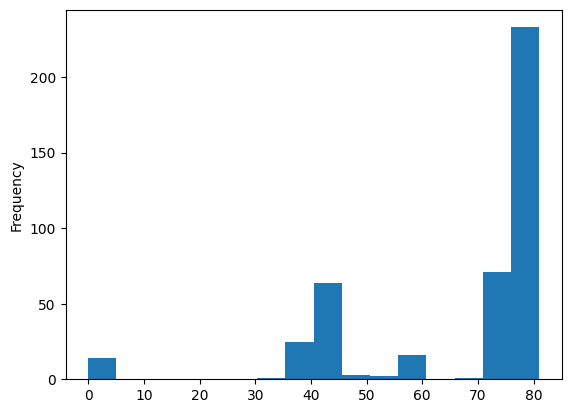

In [193]:
max_count = features_df.groupby('site').count().max(axis=1)
max_count.plot.hist(bins=16)